In [127]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
from scipy.optimize import curve_fit
import glob


In [244]:
def gaussian(x, mu, sigma, A):
    return A*np.exp(-((x-mu)/(2*sigma))**2)

def computeCoincidence(fileName, width, time_window, showHist = False):
    # Time measurment unit: 81 ps
    # Intervals and bin width are in nanoseconds

    data = pd.read_table(fileName, sep=';', names=('times', 'channel'))
    times = np.array(data['times']) * 81/1e3 
    
    nrows = data.count('index').iloc[0]
    odds, evens  = [i for i in range(nrows) if i%2 == 1], [i for i in range(nrows) if i%2 == 0]
    intervals = times[evens] - times[odds]
    bins = np.arange(-4, 4, width)
    counts, breaks = np.histogram(intervals, bins)

    centers = (breaks[1:] + breaks[:-1])/2
    params, _ = curve_fit(gaussian, centers, counts, (0, 10, 2e4))

    # If showHist is True, it returns a temporal window given by 4 sigmas interval
    # If showHist is False, we return the coincidences inside the provided time window

    if showHist:
        window = sorted([params[0]-4*params[1], params[0]+4*params[1]])
        t_range = np.linspace(min(centers), max(centers), 10**4)
        plt.hist(intervals, bins, histtype='step', color="green")
        plt.errorbar(centers, counts, np.sqrt(counts), fmt='go', capsize=2, ms=2, label="Measures")
        plt.plot(t_range, gaussian(t_range, *params), c="grey", label="Gaussian fit")
        plt.vlines(window, 0, max(counts), linestyles='dashed', label=f'{round(window[0], 2)} ns, {round(window[1], 2)} ns')
        plt.xlabel(r"$\Delta t$ [ns]")
        plt.ylabel("Counts")
        plt.title(f'Coincidences histogram for {fileName[fileName.find('x'):fileName.find('.txt')]}')
        plt.legend()
        return sorted(window)
    else:
        # We return the counts inside the time window
        coincidences = sum([counts[i] for i in range(len(counts)) if (breaks[i] > time_window[0] and breaks[i] < time_window[1])])
        error = np.sqrt(coincidences)
        return (coincidences, error)

(12032, 109.6904736064167)


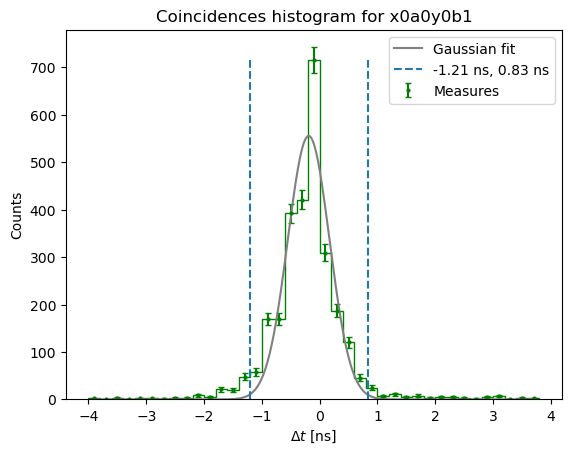

In [245]:
time_window = computeCoincidence('clean_data_Old/x0a0y0b1.txt', 0.2, 0, True)
print(computeCoincidence('clean_data_Old/x1a1y0b1.txt', 0.2, time_window, False))

Correlation between operators $\mathcal{A}, \, \mathcal{B}$ is given by $$ \text{Corr}(\mathcal{A}, \mathcal{B}) = \frac{N_{++} + N_{--} - N_{+-} - N_{-+}}{N_{++} + N_{--} + N_{+-} + N_{-+}} $$ where, for example, $N_{++}$ is the numbers of coincidences of outcomes $a = +1, \, b=+1$

In [ ]:
files = glob.glob('./clean_data_Old/*')
coincidences  = [computeCoincidence(file, 0.2, time_window, False) for file in files]
best_val, errors = [value[0] for value in coincidences], [value[1] for value in coincidences]
clean_names  = [file[file.find('x'):file.find('.txt')] for file in files]
measures, errors_     = dict(zip(clean_names, best_val)), dict(zip(clean_names, errors))

# For Alice 0,1 are respectively H and V states, for Bob 0,1 are D and A states
joint_operators = list(product([0, 1], repeat=2)) 
correlations, corr_errors = dict(zip(joint_operators, [0]*4)) , dict(zip(joint_operators, [0]*4))


'''
VERIFICA I CONTI
'''

for operators in joint_operators:
    # We fix the measured operators and collect the counting of the coincidences for each combination of oucomes (e.g. (a=0, b=0), counts = xxx)
    chosen_files = list(filter(lambda x: x[1]==str(operators[0]) and x[-3]==str(operators[1]), clean_names))
    denom = sum([measures[x] for x in chosen_files])
    num   = 0
    for chosen in chosen_files:
        if chosen[3] == chosen[-1]:
            num += measures[chosen]
        else: 
            num -= measures[chosen]
    correlations[operators] = num/denom
    corr_errors[operators]  = num/denom * np.sqrt(sum([errors_[x]**2 for x in chosen_files]) * (1/num**2 + 1/denom**2))

S_chsh  = correlations[(0,0)] + correlations[(0,1)] + correlations[(1,0)] - correlations[(1,1)]
S_error = np.sqrt(np.sum([corr_errors[op]**2 for op in joint_operators]))
print(f'Schsh: {S_chsh} ± {S_error}')

Schsh: 2.534038343930214 ± 0.01374900183238462
